# Import depecdencies

In [1]:
import os
import shutil
import matplotlib
import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import os.path as osp
from plottable.cmap import normed_cmap
import matplotlib.pyplot as plt
from matplotlib.cm import Greens, Reds

from sklearn.preprocessing import MinMaxScaler

from plottable import ColumnDefinition
from plottable import Table
from plottable.formatters import decimal_to_percent
from configs.general import EXPERIMENT_INFO_PATH, BASE_DIR,\
      EXPERIMENT_BASE_DIR, EXPERIMENT_COLS, DATA_FILTERING_POLICIES,\
        DATA_RETRIEVAL_POLICIES, PHASES,\
        FILTERING_EXPERIMENT_INFO_PATH

from utils.plot import draw_stacked_bars
from metric.level2.id2m import IntegralDiff2Max
          

METRIC_NAME = "id2m"
scaler = MinMaxScaler()

# Calculate correctness for each experiment 

In [8]:
def load_experiments_with_auc_of_metric(path, index_col):
    experiments_with_auc_of_metric = None
    try:
        experiments_with_auc_of_metric = pd.read_csv(path, index_col=index_col)
    except Exception as e:
        print(e)
    return experiments_with_auc_of_metric

def load_experiments(path, index_col):
    experiments = pd.read_csv(path, index_col=index_col)
    try:
        experiments.drop(columns=['test_acc'], inplace=True)
    except Exception as e:
        print(e)
    return experiments

def filter_out_auc_calculated_experiments(experiments, experiments_with_auc_of_metric):
    experiments['has_auc'] = False
    for idx in experiments_with_auc_of_metric.index:
        if idx in experiments.index:
            experiments.loc[idx, 'has_auc'] = True
    
    return experiments[(experiments['has_auc'] == False)]

In [16]:
experiments = load_experiments(osp.join(BASE_DIR, "experiments.csv"), index_col='index')
experiments['has_auc'] = False
experiments = experiments[(experiments['done'] == True)]
experiments_with_auc_of_metric = load_experiments_with_auc_of_metric(osp.join(BASE_DIR,f"{METRIC_NAME}_auc.csv"), index_col='index')

if (experiments_with_auc_of_metric is not None) and (not experiments_with_auc_of_metric.empty):
    experiments = filter_out_auc_calculated_experiments(experiments, experiments_with_auc_of_metric)

for phase in PHASES:
    experiments[f"{METRIC_NAME}-{phase}-auc"] = 0.0

for index, row in experiments.iterrows():
    metric = IntegralDiff2Max(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")

    result = metric.calculate_metric_per_phase(scale=True)
    metric_auc = metric.calculate_auc_per_phase(result)
    for phase in PHASES:
        experiments.at[index, f"{METRIC_NAME}-{phase}-auc"] = metric_auc[phase]
    experiments.at[index, "has_auc"] = True


In [17]:
experiments = experiments[(experiments["has_auc"] == True)]
path = osp.join(BASE_DIR, f"{METRIC_NAME}_auc.csv")
if osp.exists(path):
    shutil.copy(path, path+".swp")
if (experiments_with_auc_of_metric is not None) and (not experiments_with_auc_of_metric.empty):
    experiments_with_auc_of_metric = experiments_with_auc_of_metric._append(experiments.drop(columns=['has_auc']))
    experiments_with_auc_of_metric.sort_index(inplace=True)
    experiments_with_auc_of_metric.to_csv(path)
else:
    experiments.drop(columns=['has_auc'], inplace=True)
    experiments.sort_index(inplace=True)
    experiments.to_csv(osp.join(path))

# Best Settings with xception model based on correctness AUC

### Plot Best AUC for train and validation phase

In [18]:
experiments_with_auc = pd.read_csv(osp.join(BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
experiments_with_auc = experiments_with_auc.dropna()
experiments_with_auc = experiments_with_auc[experiments_with_auc['model'] == 'xception']

In [19]:
train_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-train-auc'].idxmax()]
val_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-validation-auc'].idxmax()]

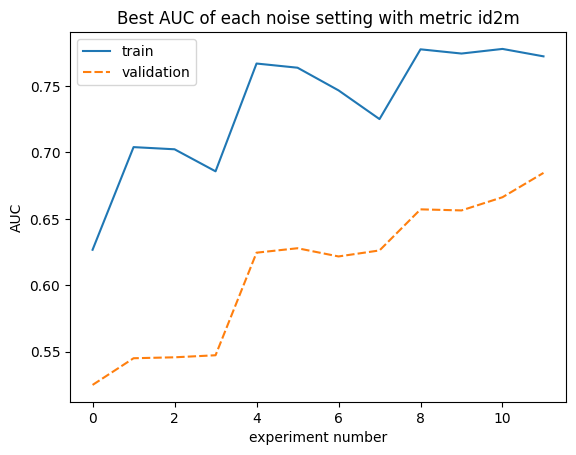

In [20]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(
    data=pd.DataFrame(
        {
            f'train': train_max_auc_rows.reset_index()[f'{METRIC_NAME}-train-auc'],
            f'validation': val_max_auc_rows.reset_index()[f'{METRIC_NAME}-validation-auc'],
        }))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

In [21]:
# based on above plot we select 'train' phase
max_auc_rows = train_max_auc_rows.copy()
winner_phase = 'train'

### Plot best settings for each noise setting according to metric

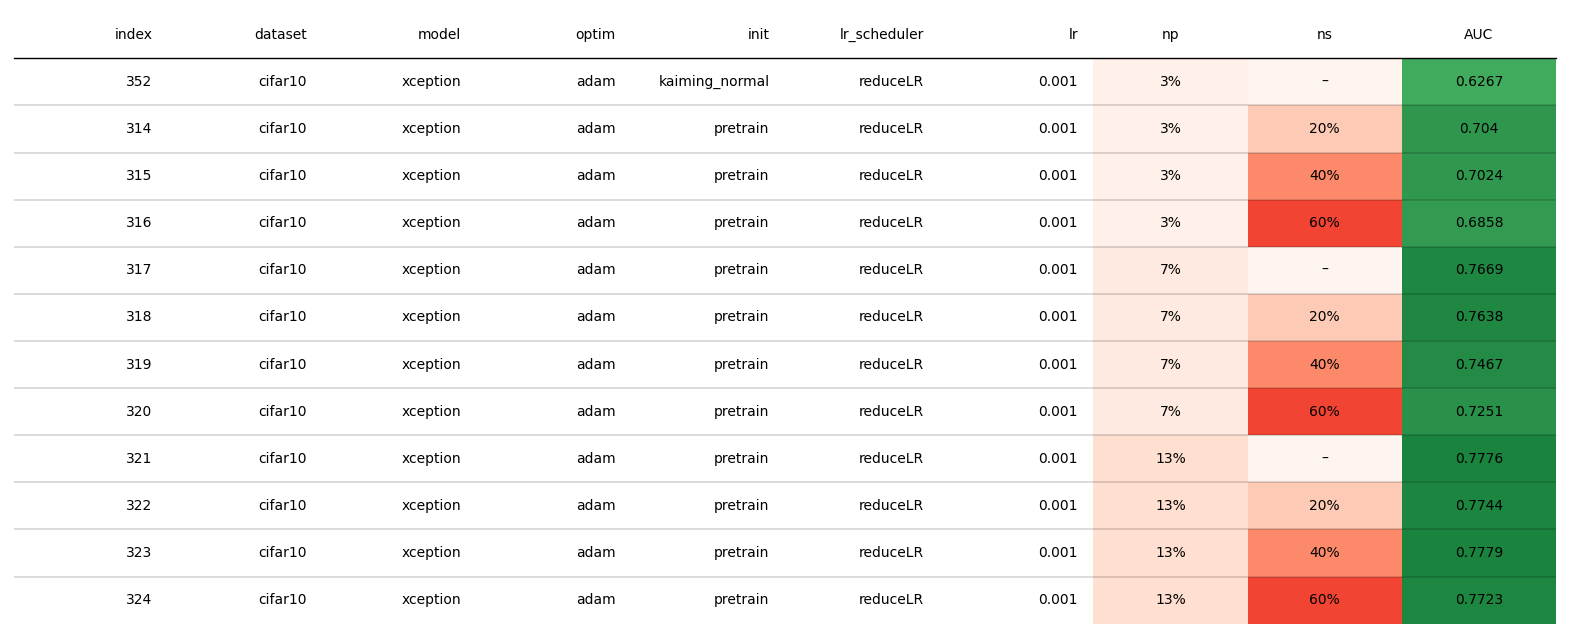

In [22]:
# Init a figure
fig, ax = plt.subplots(figsize=(20, 8))
df = max_auc_rows.copy()
df['np'] = max_auc_rows['np'].str.replace('np=', '').astype(float)
df['ns'] = max_auc_rows['ns'].str.replace('ns=', '').astype(float)
df['lr'] = max_auc_rows['lr'].str.replace('lr=', '').astype(float)
df['AUC'] = max_auc_rows[f'{METRIC_NAME}-{winner_phase}-auc'].round(4)
df = df[['dataset','model', 'optim', 'init', 'lr_scheduler', 'lr', 'np', 'ns', 'AUC']]
tab = Table(df, column_definitions=[
    ColumnDefinition(name="AUC", cmap=Greens, textprops= {"ha": "center"}),
    ColumnDefinition(name="np", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="ns", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

In [24]:
print(f"Top experiments based on metric {METRIC_NAME}: ", df.index.tolist())

Top experiments based on metric id2m:  [352, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324]


### Generate database for filtering policies based on this metric

In [25]:
# Generate database for filtering policies based on this metric
new_df = pd.DataFrame()
for experiment_index in max_auc_rows.index.tolist():
    for filtering_policy in DATA_FILTERING_POLICIES:
        for retrieval_policy in DATA_RETRIEVAL_POLICIES:
            new_df = new_df._append({'basic_experiment_index': experiment_index, 'data_filtering_policy': filtering_policy, 'data_retrieval_policy': retrieval_policy}, ignore_index=True)
new_df['based_on'] = METRIC_NAME
new_df['done'] = False
new_df.index.name = 'index'

path = osp.join(BASE_DIR, 'filtering_experiments.csv')
if osp.exists(path):
    shutil.copy(path, path+".swp")
    old_df = pd.read_csv(path, index_col='index')
    new_df = new_df._append(old_df, ignore_index=True)
    new_df = new_df.drop_duplicates(subset=['basic_experiment_index', 'data_filtering_policy', 'data_retrieval_policy', 'based_on'], keep='last').sort_values('basic_experiment_index').reset_index(drop=True)
if not osp.isdir(osp.dirname(path)):
    os.makedirs(osp.dirname(path))
new_df.to_csv(path, index_label='index')

### Write metric per sample for best experiment settings

In [7]:
for index, row in max_auc_rows.iterrows():
    metric = IntegralDiff2Max(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")
    path = osp.join(metric.experiment_dir, f"{METRIC_NAME}_per_sample.csv")
    if osp.exists(path):
        print(f"{METRIC_NAME} auc already exist in {path}")
        continue
    result = metric.calculate_metric_per_phase(scale=True)
    result = result[result['phase']==winner_phase].drop(columns=['phase'])
    result.set_index('sample', inplace=True)
    result.to_csv(path, index='sample')

id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.03/ns=0.2/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.03/ns=0.4/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.03/ns=0.6/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.07/ns=0.0/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.07/ns=0.2/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/Repo/cleanset/logs/basic_experiments/cifar10/xception/adam/pretrain/reduceLR/np=0.13/ns=0.0/lr=0.001/id2m_per_sample.csv
id2m auc already exist in /home/vision/R

# Best settings based on id2m AUC

In [5]:
experiments_with_auc = pd.read_csv(osp.join(BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
experiments_with_auc = experiments_with_auc.dropna()
train_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-train-auc'].idxmax()]
val_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-validation-auc'].idxmax()]

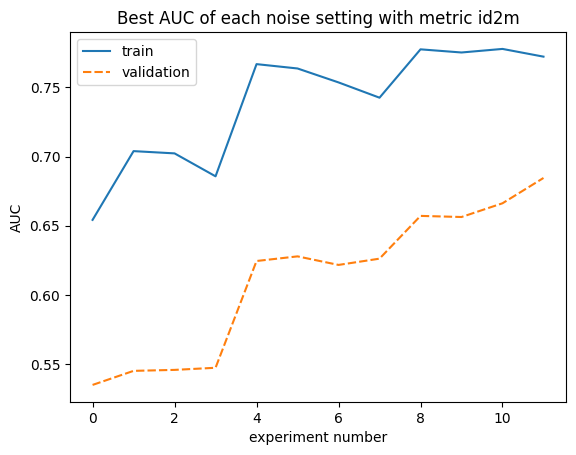

In [3]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(
    data=pd.DataFrame(
        {
            f'train': train_max_auc_rows.reset_index()[f'{METRIC_NAME}-train-auc'],
            f'validation': val_max_auc_rows.reset_index()[f'{METRIC_NAME}-validation-auc'],
        }))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

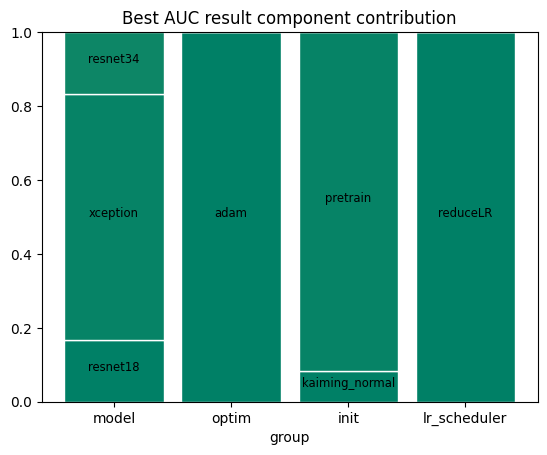

In [6]:
# based on above plot we select 'train' phase
max_auc_rows = train_max_auc_rows.copy()
winner_phase = 'train'
max_auc_rows = max_auc_rows[['model', 'optim', 'init', 'lr_scheduler']]
draw_stacked_bars(max_auc_rows)

# Test acc before and after filtering data based on correctness

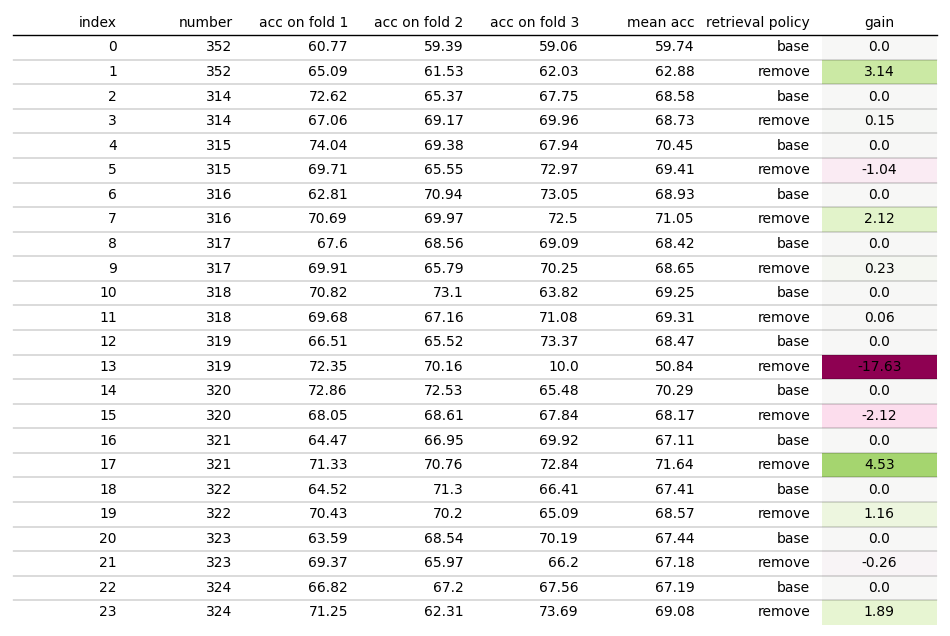

In [10]:
METRIC_NAME = "correctness"
BEST_PHASE = 'train'

result = pd.DataFrame()
try:
    target_experiments_indices = max_auc_rows.index.values()
except:
    target_experiments_indices = [352, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324]

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index').iloc[target_experiments_indices]
filtering_experience = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')
filtering_experience = filtering_experience[filtering_experience['based_on'] == 'correctness']
for index, row in target_experiments.iterrows():
    fex = filtering_experience[filtering_experience['basic_experiment_index'].isin([index]) & \
                                (filtering_experience['done'] == True)]
    test_acc = [float(x) for x in row['test_acc'].split()]

    result = result._append({
        'number': index,
        'acc on fold 1': test_acc[0],
        'acc on fold 2': test_acc[1],
        'acc on fold 3': test_acc[2],
        'mean acc': np.mean(test_acc).round(2),
        'retrieval policy': 'base',
        }, ignore_index = True)

    for findex, frow in fex.iterrows():
        test_acc = [float(x) for x in frow['test_acc'].split()]
        result = result._append({
            'number': index,
            'acc on fold 1': test_acc[0],
            'acc on fold 2': test_acc[1],
            'acc on fold 3': test_acc[2],
            'mean acc': np.mean(test_acc).round(2),
            'retrieval policy': frow['data_retrieval_policy'],
            }, ignore_index = True)
        
base_result = pd.DataFrame()
base_result['number'] = result['number']
base_result['base acc'] = 0.0
for index, row in base_result.iterrows():
    base_result.at[index, 'base acc'] = result[(result['number'] == row['number']) & (result['retrieval policy'] == 'base')].iloc[0]['mean acc']
gain = ((result['mean acc'] - base_result['base acc'])).round(2)
result['gain'] = gain

# Init a figure
fig, ax = plt.subplots(figsize=(12, 8))
tab = Table(result, column_definitions=[
    ColumnDefinition(
        name="gain",
        cmap=normed_cmap(
            result["gain"],
            cmap=matplotlib.cm.PiYG, num_stds=2.5),
        textprops={"ha": "center"})
])
# Display the output
plt.show()
